In [ ]:
'''
1. データセットの読み込みと前処理を行う関数
'''
import numpy as np
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

def prepare_data():
    """データを用意する
    
    Returns:
    X_train(ndarray):
        訓練データ(50000,32,32,3)
    X_test(ndarray):
        テストデータ(10000,32,32,3)
    y_train(ndarray):
        訓練データのOne-Hot化した正解ラベル(50000,)
    y_test(ndarray):
        テストデータのOne-Hot化した正解ラベル(10000,)
    """
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    
    # 訓練用とテスト用の画像データを正規化する
    x_train, x_test = x_train.astype('float32'), x_test.astype('float32')
    x_train, x_test = x_train/255.0, x_test/255.0
        
    # 訓練データとテストデータの正解ラベルを10クラスのOne-Hot表現に変換
    y_train, y_test = to_categorical(y_train), to_categorical(y_test)
    
    return x_train, x_test, y_train, y_test

In [ ]:
'''
2. モデルを構築する関数
'''
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten # core layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D    # convolution layers
from tensorflow.keras import optimizers

def make_convlayer():
    # Sequentialオブジェクトを生成
    model = Sequential()

    # 第1層: 畳み込み層1
    # (バッチサイズ,32,3,3) -> (バッチサイズ,32,32,32)
    model.add(
        Conv2D(
            filters=32,                    # フィルターの数は32
            kernel_size=(3,3),             # 3x3のフィルターを使用
            input_shape=x_train[0].shape,  # 入力データの形状
            padding='same',                # ゼロパディングを行う 
            activation='relu'              # 活性化関数はReLU
            ))

    # 第2層: 畳み込み層2
    # (バッチサイズ,32,32,32) ->(バッチサイズ,32,32,32)
    model.add(
        Conv2D(filters=32,              # フィルターの数は32
            kernel_size=(3,3),          # 3×3のフィルターを使用
            padding='same',             # ゼロパディングを行う 
            activation='relu'           # 活性化関数はReLU
            ))

    # 第3層: プーリング層1: ウィンドウサイズは2×2
    # (バッチサイズ,32,32,32) -> (バッチサイズ,16,16,32)
    model.add(MaxPooling2D(pool_size=(2,2)))
    # ドロップアウト1：ドロップアウトは50％
    model.add(Dropout(0.5))
    
    # 第4層: 畳み込み層3
    # (バッチサイズ,16,16,32) ->(バッチサイズ,16,16,64)
    model.add(
        Conv2D(filters=64,              # フィルターの数は64
            kernel_size=(3,3),          # 3×3のフィルターを使用
            padding='same',             # ゼロパディングを行う 
            activation='relu'           # 活性化関数はReLU
            ))

    # 第5層: 畳み込み層4
    # (バッチサイズ,64,16,16) ->(バッチサイズ,64,16,16)
    model.add(
        Conv2D(filters=64,              # フィルターの数は64
            kernel_size=(3,3),          # 3×3のフィルターを使用
            padding='same',             # ゼロパディングを行う 
            activation='relu'           # 活性化関数はReLU
            ))
    
    # 第6層: プーリング層2: ウィンドウサイズは2×2
    # (バッチサイズ,16,16,64) -> (バッチサイズ,8,8,64)
    model.add(MaxPooling2D(pool_size=(2,2)))
    # ドロップアウト2：ドロップアウトは50％
    model.add(Dropout(0.5))
    
    # Flatten: 4階テンソルから2階テンソルに変換
    # (バッチサイズ,4,4,128) -> (バッチサイズ,2048)
    model.add(Flatten())

    # 第10層: 全結合層
    # (バッチサイズ,2048) -> (バッチサイズ,128)
    model.add(Dense(512,                # ニューロン数は512
                    activation='relu')) # 活性化関数はReLU
    # ドロップアウト3：ドロップアウトは50％
    model.add(Dropout(0.5))

    # 第11層: 出力層
    # (バッチサイズ,512) -> (バッチサイズ,10)
    model.add(Dense(10,                    # 出力層のニューロン数は10
                    activation='softmax')) # 活性化関数はソフトマックス

    # Sequentialオブジェクトのコンパイル
    model.compile(
        loss='categorical_crossentropy', # クロスエントロピー誤差
        optimizer=optimizers.Adam(lr=0.001),    # Adamを使用
        metrics=['accuracy'] # 学習評価として正解率を指定
    )

    return model

In [ ]:
'''
3. 訓練を実施する関数
'''
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def train(x_train, x_test, y_train, y_test):
    
    # val_accuracyの改善が5エポック見られなかったら、学習率を0.5倍する。
    reduce_lr = ReduceLROnPlateau(
        monitor='val_accuracy', # 監視対象は検証データの精度
        factor=0.5,             # 学習率を減衰させる割合
        patience=5,             # 監視対象のエポック数
        verbose=1,              # 学習率を下げたときに通知する
        mode='max',             # 最高値を監視する
        min_lr=0.0001           # 学習率の下限
        )
    
    model = make_convlayer()    # モデルを生成
    model.summary()             # サマリを出力

    callbacks_list = [reduce_lr]

    # データ拡張
    datagen = ImageDataGenerator(
        width_shift_range=0.1,  # 横サイズの0.1の割合でランダムに水平移動
        height_shift_range=0.1, # 縦サイズの0.1の割合でランダムに垂直移動
        rotation_range=10,      # 10度の範囲でランダムに回転させる
        zoom_range=0.1,         # ランダムに拡大
        horizontal_flip=True)   # 左右反転

    # ミニバッチのサイズ
    batch_size = 64
    # 学習回数
    epochs = 120

    # 学習を行う
    history = model.fit(
        # 訓練データと正解ラベル
        x_train,  y_train,
        batch_size=batch_size,
        epochs=epochs, # 学習回数
        verbose=1,     # 学習の進捗状況を出力する
        validation_split= 0.2,   # 検証データとして使用する割合
        shuffle=True,  # 検証データを抽出する際にシャッフルする
        callbacks=callbacks_list # 1エポック終了ごとに学習率減衰をコールバック
        )
    # テストデータでモデルを評価する
    score = model.evaluate(x_test, y_test, verbose=0)
    # テストデータの損失を出力
    print('Test loss:', score[0])
    # テストデータの精度を出力
    print('Test accuracy:', score[1])
    return history

In [ ]:
'''
4. データを用意する
'''
x_train, x_test, y_train, y_test = prepare_data()

In [ ]:
%%time
'''
5. 訓練の実施
'''
history = train(x_train, x_test, y_train, y_test)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0

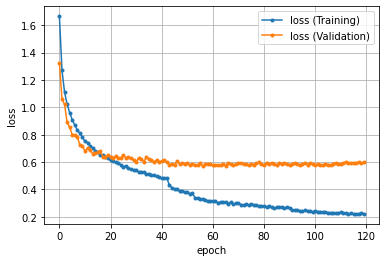

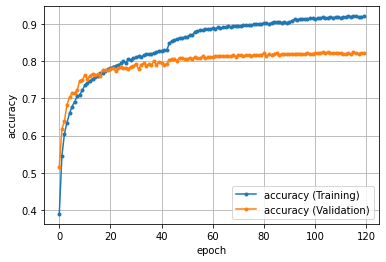

In [ ]:
'''
6. 損失と精度の推移をグラフにする
'''
import matplotlib.pyplot as plt
%matplotlib inline

# 学習結果（損失）のグラフを描画
plt.plot(history.history['loss'],
         marker='.',
         label='loss (Training)')
plt.plot(history.history['val_loss'],
         marker='.',
         label='loss (Validation)')
plt.legend(loc='best')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

# 学習結果（精度）のグラフを描画
plt.plot(history.history['accuracy'],
         marker='.',
         label='accuracy (Training)')
plt.plot(history.history['val_accuracy'],
         marker='.',
         label='accuracy (Validation)')
plt.legend(loc='best')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()